In [67]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [23]:
df = pd.read_csv("state_of_the_data_dataset.csv")

df.head()

,0.a_token,0.d_data/hora_envio,1.a_idade,1.a.1_faixa_idade,1.b_genero,1.c_cor/raca/etnia,1.d_pcd,1.e_experiencia_profissional_prejudicada,1.e.1_Não acredito que minha experiência profissional seja afetada,"1.e.2_Sim, devido a minha Cor/Raça/Etnia",...,"8.d.3_Entrando em contato com os times de negócio para definição do problema, identificar a solução e apresentação de resultados.",8.d.4_Desenvolvendo modelos de Machine Learning com o objetivo de colocar em produção em sistemas (produtos de dados).,"8.d.5_Colocando modelos em produção, criando os pipelines de dados, APIs de consumo e monitoramento.","8.d.6_Cuidando da manutenção de modelos de Machine Learning já em produção, atuando no monitoramento, ajustes e refatoração quando necessário.","8.d.7_Realizando construções de dashboards em ferramentas de BI como PowerBI, Tableau, Looker, Qlik, etc.","8.d.8_Utilizando ferramentas avançadas de estatística como SAS, SPSS, Stata etc, para realizar análises.","8.d.9_Criando e dando manutenção em ETLs, DAGs e automações de pipelines de dados.",8.d.10_Criando e gerenciando soluções de Feature Store e cultura de MLOps.,"8.d.11_Criando e mantendo a infra que meus modelos e soluções rodam (clusters, servidores, API, containers, etc.)",8.d.12_Treinando e aplicando LLM's para solucionar problemas de negócio.
0,reb94rv0msth7q4nreb94riaq80iz3yi,16/10/2024 11:19:17,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1zc66g69jjt49y32l1zc66g8wqj79m4e,16/10/2024 20:45:31,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,uu99wmam4n5kc2uu99wmydf0rk7l58f7,17/10/2024 18:10:59,18,17-21,Masculino,Parda,Não,Não acredito que minha experiência profissiona...,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3ynsw7z0hl5hhpbfvaeqk73ynsw7z04l,22/10/2024 18:03:00,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,v6bji2ct5xckpl1uouv6bjiotkrf3b4f,23/10/2024 01:33:23,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Definimos **oito quasi-identificadores**. São eles:

In [48]:
quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    '2.i_tempo_de_experiencia_em_dados',
    '2.j_tempo_de_experiencia_em_ti',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    '1.b_genero',
    '2.f_cargo_atual',
    '2.b_setor',
    '2.c_numero_de_funcionarios'
]

for col in quasi_identifiers:
    print(df[col].unique())
    print("\n")

['RS' 'SC' 'SP' 'DF' 'MA' 'BA' 'MG' 'PR' 'MT' 'GO' 'AL' 'PB' 'PE' 'RJ'
 'ES' 'AP' 'CE' 'TO' 'PI' 'MS' 'RN' 'AM' nan 'RO' 'SE' 'PA']


['de 1 a 2 anos' 'Menos de 1 ano' 'Não tenho experiência na área de dados'
 nan 'de 5 a 6 anos' 'de 3 a 4 anos' 'de 7 a 10 anos' 'Mais de 10 anos']


['de 1 a 2 anos' 'Menos de 1 ano'
 'Não tive experiência na área de TI/Engenharia de Software antes de começar a trabalhar na área de dados'
 nan 'de 3 a 4 anos' 'de 5 a 6 anos' 'de 7 a 10 anos' 'Mais de 10 anos']


['Estudante de Graduação' 'Graduação/Bacharelado'
 'Não tenho graduação formal' 'Prefiro não informar' 'Pós-graduação'
 'Doutorado ou Phd' 'Mestrado']


['Computação / Engenharia de Software / Sistemas de Informação/ TI'
 'Economia/ Administração / Contabilidade / Finanças/ Negócios' nan
 'Estatística/ Matemática / Matemática Computacional/ Ciências Atuariais'
 'Outra opção'
 'Outras Engenharias (não incluir engenharia de software ou TI)'
 'Ciências Biológicas/ Farmácia/ Medicina/ Área da Saúde'

Esses atributos foram escolhidos porque podem ser extraídos com alto grau de precisão a partir de um scraping de perfis no LinkedIn. Assim, representam atributos de alto risco para reidentificação.

## Premissa Geral

Estamos considerando que **é razoável assumir que os perfis do LinkedIn coletados correspondem a indivíduos presentes no dataset *State-of-the-Data***. Essa suposição se fundamenta no fato de que os perfis foram extraídos a partir de interações (como curtidas) em posts de divulgação da própria pesquisa — posts que explicitamente convidavam profissionais da área de dados a respondê-la.

Embora não seja possível garantir com certeza absoluta que todos esses indivíduos efetivamente participaram da pesquisa, essa hipótese é razoável o suficiente para fins de análise. Com base nela, adotamos o seguinte raciocínio:

> **Se existe uma classe de equivalência de tamanho 1 formada por um conjunto de quasi-identificadores que também estão presentes no perfil de um indivíduo do LinkedIn, então é razoável assumir que sabemos quem é aquela pessoa no dataset.**


## Perguntas a serem respondidas

> **Esses oito quasi-identificadores são suficientes para identificar unicamente indivíduos do dataset?**

Para isso, vamos agrupar os registros utilizando os oito quasi-identificadores e observar a distribuição do tamanho das classes de equivalência. Se houver muitas classes com tamanho 1, isso indica uma alta capacidade de reidentificação — o que compromete o anonimato.
* **É necessário usar todos os oito?**
* **Qual o menor subconjunto que já gera pelo menos uma classe de equivalência de tamanho 1?**
* **Como varia o risco de reidentificação conforme aumentamos o número de quasi-identificadores utilizados?**



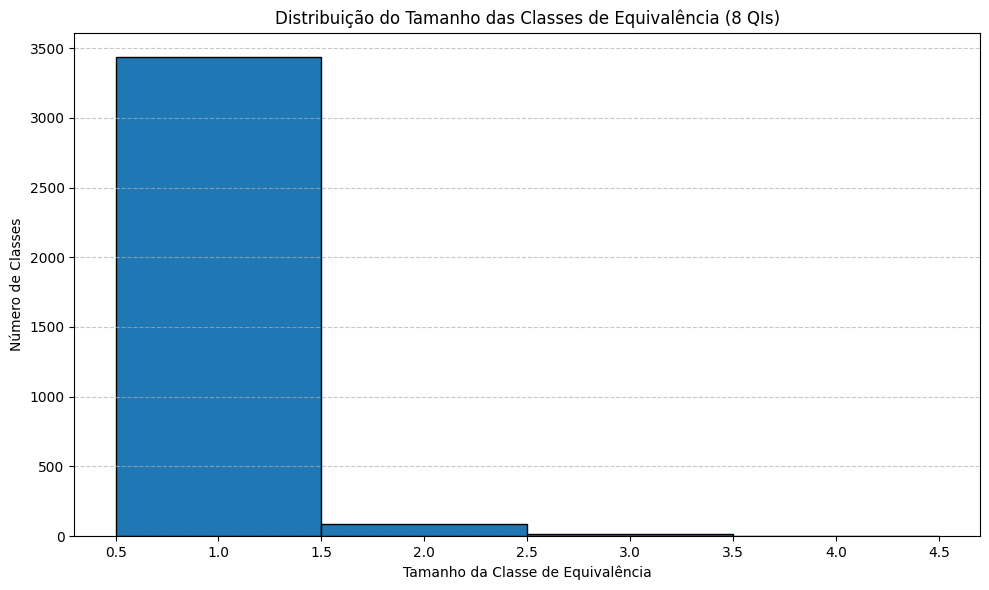

Número de classes de equivalência com tamanho 1: 3437
Número de classes de equivalência com tamanho 2: 87
Número de classes de equivalência com tamanho 3: 15
Total de classes de equivalência: 3540


In [30]:
grupos = df.groupby(quasi_identifiers).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.hist(grupos['count'], bins=range(1, grupos['count'].max() + 2), edgecolor='black', align='left')
plt.title('Distribuição do Tamanho das Classes de Equivalência (8 QIs)')
plt.xlabel('Tamanho da Classe de Equivalência')
plt.ylabel('Número de Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

num_grupos_tam_1 = (grupos['count'] == 1).sum()
num_grupos_tam_2 = (grupos['count'] == 2).sum()
num_grupos_tam_3 = (grupos['count'] == 3).sum()
total_grupos = len(grupos)
print(f'Número de classes de equivalência com tamanho 1: {num_grupos_tam_1}')
print(f'Número de classes de equivalência com tamanho 2: {num_grupos_tam_2}')
print(f'Número de classes de equivalência com tamanho 3: {num_grupos_tam_3}')
print(f'Total de classes de equivalência: {total_grupos}')


Ao utilizar os oito quasi-identificadores, obtemos 3.437 classes de equivalência com tamanho 1, em um total de 5.217 registros. Ademais, tempos apenas 87 classes de equivalência de tamanho 2 e 15 de tamanho 3. Isso é um forte indício de que esses identificadores, em conjunto, são suficientes para possibilitar a reidentificação de indivíduos.

No entanto, dois dos atributos utilizados — tempo de experiência em dados e tempo de experiência em TI — não são completamente confiáveis a partir de perfis do LinkedIn, pois dependem da forma como a pessoa descreve sua trajetória profissional e podem estar sujeitos a omissões ou interpretações diferentes.

Diante disso, surge a próxima pergunta:

> Se retirarmos esses dois campos, ainda assim conseguimos formar classes de equivalência com tamanho 1?

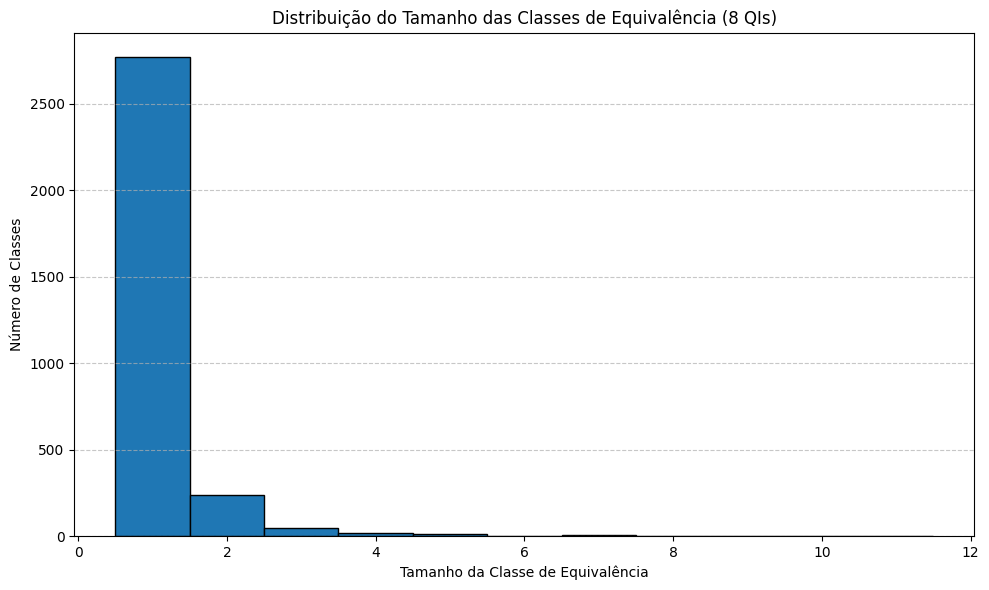

Número de classes de equivalência com tamanho 1: 2770
Número de classes de equivalência com tamanho 2: 236
Número de classes de equivalência com tamanho 3: 50
Total de classes de equivalência: 3103


In [32]:
quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    # '2.i_tempo_de_experiencia_em_dados',
    # '2.j_tempo_de_experiencia_em_ti',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    '2.b_setor',
    '2.c_numero_de_funcionarios',
    '2.f_cargo_atual'
]

grupos = df.groupby(quasi_identifiers).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.hist(grupos['count'], bins=range(1, grupos['count'].max() + 2), edgecolor='black', align='left')
plt.title('Distribuição do Tamanho das Classes de Equivalência (8 QIs)')
plt.xlabel('Tamanho da Classe de Equivalência')
plt.ylabel('Número de Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

num_grupos_tam_1 = (grupos['count'] == 1).sum()
num_grupos_tam_2 = (grupos['count'] == 2).sum()
num_grupos_tam_3 = (grupos['count'] == 3).sum()
total_grupos = len(grupos)
print(f'Número de classes de equivalência com tamanho 1: {num_grupos_tam_1}')
print(f'Número de classes de equivalência com tamanho 2: {num_grupos_tam_2}')
print(f'Número de classes de equivalência com tamanho 3: {num_grupos_tam_3}')
print(f'Total de classes de equivalência: {total_grupos}')

Ao remover os dois quasi-identificadores (`tempo de experiência em dados` e `tempo de experiência em TI`), ainda assim observamos um risco relevante de reidentificação:

* **2.270 classes de equivalência têm tamanho 1**, ou seja, 2.270 indivíduos ainda podem ser identificados unicamente.
* Outras **236 classes têm tamanho 2**, o que significa que, ao observar alguém com essas características no LinkedIn, temos **50% de chance** de acertar qual indivíduo é aquele no dataset.

Portanto, mesmo **sem os dois atributos menos confiáveis**, a estrutura do dataset já permite um grau preocupante de reidentificação. Com os oito quasi-identificadores, o potencial de identificar pessoas com precisão é ainda mais elevado.

In [34]:
quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    '2.f_cargo_atual',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    '2.i_tempo_de_experiencia_em_dados',
    '2.j_tempo_de_experiencia_em_ti',
    '2.b_setor',
    '2.c_numero_de_funcionarios',
]

def analisar_distribuicoes(df, quasi_identifiers):
    estatisticas = []

    for r in range(1, len(quasi_identifiers) + 1):
        for combinacao in itertools.combinations(quasi_identifiers, r):
            grupos = df.groupby(list(combinacao)).size()
            counts = grupos.value_counts().sort_index()

            total_grupos = len(grupos)
            grupos_tam_1 = (grupos == 1).sum()
            min_tam = grupos.min()
            max_tam = grupos.max()
            media_tam = grupos.mean()

            estatisticas.append({
                'num_qi': r,
                'combinacao': combinacao,
                'total_grupos': total_grupos,
                'grupos_tamanho_1': grupos_tam_1,
                'proporcao_tam_1': grupos_tam_1 / total_grupos,
                'min_tamanho': min_tam,
                'max_tamanho': max_tam,
                'media_tamanho': media_tam
            })

    return pd.DataFrame(estatisticas)

estatisticas_df = analisar_distribuicoes(df, quasi_identifiers)


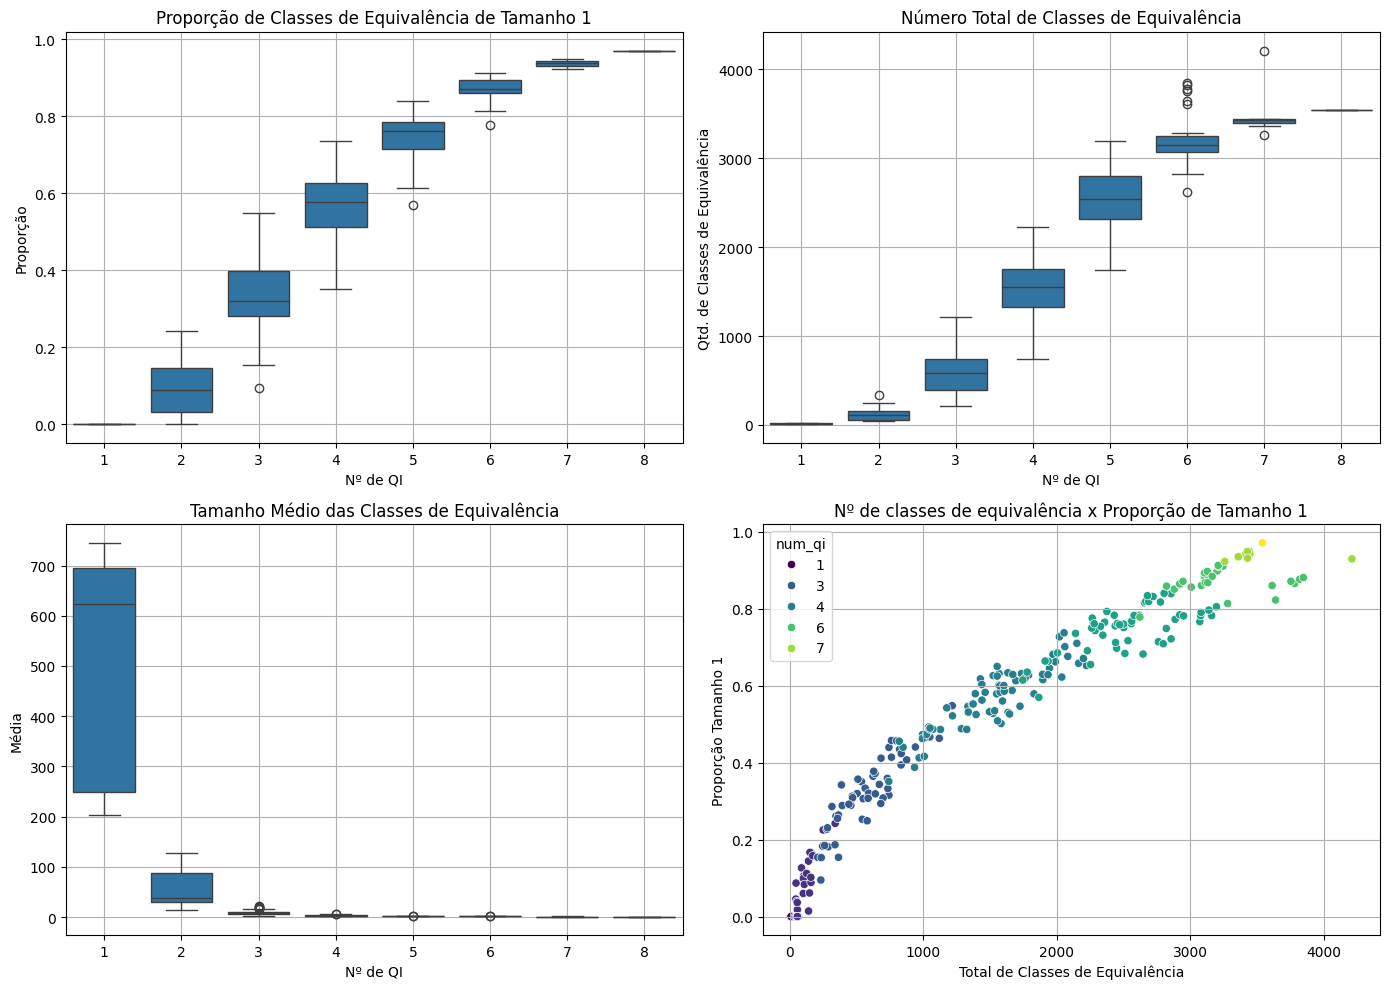

In [47]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='num_qi', y='proporcao_tam_1', data=estatisticas_df)
plt.title('Proporção de Classes de Equivalência de Tamanho 1')
plt.xlabel('Nº de QI')
plt.ylabel('Proporção')
plt.grid(True)

plt.subplot(2, 2, 2)
sns.boxplot(x='num_qi', y='total_grupos', data=estatisticas_df)
plt.title('Número Total de Classes de Equivalência')
plt.xlabel('Nº de QI')
plt.ylabel('Qtd. de Classes de Equivalência')
plt.grid(True)

plt.subplot(2, 2, 3)
sns.boxplot(x='num_qi', y='media_tamanho', data=estatisticas_df)
plt.title('Tamanho Médio das Classes de Equivalência')
plt.xlabel('Nº de QI')
plt.ylabel('Média')
plt.grid(True)

plt.subplot(2, 2, 4)
sns.scatterplot(x='total_grupos', y='proporcao_tam_1', hue='num_qi', data=estatisticas_df, palette='viridis')
plt.title('Nº de classes de equivalência x Proporção de Tamanho 1')
plt.xlabel('Total de Classes de Equivalência')
plt.ylabel('Proporção Tamanho 1')
plt.grid(True)

plt.tight_layout()
plt.show()


In [42]:
linha_max = estatisticas_df.loc[estatisticas_df['proporcao_tam_1'].idxmax()]

print("Número de quasi-identificadores:", linha_max['num_qi'])
print("Combinação responsável:", linha_max['combinacao'])
print("Total de grupos (classes de equivalência):", linha_max['total_grupos'])
print("Grupos com tamanho 1:", linha_max['grupos_tamanho_1'])
print("Proporção de grupos com tamanho 1:", f"{linha_max['proporcao_tam_1']:.2%}")
print("Tamanho mínimo de grupo:", linha_max['min_tamanho'])
print("Tamanho máximo de grupo:", linha_max['max_tamanho'])
print("Tamanho médio dos grupos:", f"{linha_max['media_tamanho']:.2f}")

Número de quasi-identificadores: 8
Combinação responsável: ('1.i.1_uf_onde_mora', '2.f_cargo_atual', '1.l_nivel_de_ensino', '1.m_área_de_formação', '2.i_tempo_de_experiencia_em_dados', '2.j_tempo_de_experiencia_em_ti', '2.b_setor', '2.c_numero_de_funcionarios')
Total de grupos (classes de equivalência): 3540
Grupos com tamanho 1: 3437
Proporção de grupos com tamanho 1: 97.09%
Tamanho mínimo de grupo: 1
Tamanho máximo de grupo: 4
Tamanho médio dos grupos: 1.03


In [43]:
linha_max = estatisticas_df.loc[estatisticas_df['total_grupos'].idxmax()]

print("Número de quasi-identificadores:", linha_max['num_qi'])
print("Combinação responsável:", linha_max['combinacao'])
print("Total de grupos (classes de equivalência):", linha_max['total_grupos'])
print("Grupos com tamanho 1:", linha_max['grupos_tamanho_1'])
print("Proporção de grupos com tamanho 1:", f"{linha_max['proporcao_tam_1']:.2%}")
print("Tamanho mínimo de grupo:", linha_max['min_tamanho'])
print("Tamanho máximo de grupo:", linha_max['max_tamanho'])
print("Tamanho médio dos grupos:", f"{linha_max['media_tamanho']:.2f}")

Número de quasi-identificadores: 7
Combinação responsável: ('1.i.1_uf_onde_mora', '1.l_nivel_de_ensino', '1.m_área_de_formação', '2.i_tempo_de_experiencia_em_dados', '2.j_tempo_de_experiencia_em_ti', '2.b_setor', '2.c_numero_de_funcionarios')
Total de grupos (classes de equivalência): 4211
Grupos com tamanho 1: 3913
Proporção de grupos com tamanho 1: 92.92%
Tamanho mínimo de grupo: 1
Tamanho máximo de grupo: 10
Tamanho médio dos grupos: 1.11


1. **Identificabilidade elevada**:
   Ao usar os 8 quase-identificadores, mais de **97%** das classes de equivalência têm tamanho 1, evidenciando forte capacidade de reidentificação.

2. **Com apenas 6 QIs ainda é elevado**:
   A partir de 6 quase-identificadores, a **proporção de grupos de tamanho 1 ultrapassa 80%**, indicando que **nem todos os QIs são necessários** para atingir esse grau de granularidade.

3. **Queda da média é esperada**:
   A média do tamanho dos grupos cai rapidamente — o que é esperado, já que a fragmentação cria muitos grupos de tamanho 1, e poucos grandes.

4. **Ponto ótimo (linha de dominância de Pareto)**:
   Há um ponto destacado no gráfico, que **usa apenas 7 QIs** (todos exceto `cargo_atual`), que tem **mais de 4.000 grupos únicos e alta proporção de tamanho 1**.
   Esse ponto está na **fronteira de Pareto** (não é dominado em nenhuma dimensão: nem em número de grupos nem em proporção).

### Atribuição de pesos e construção do score de confiança

Para refinar nossa análise sobre o potencial de reidentificação, atribuímos pesos a cada quasi-identificador com base no grau de confiança que temos nas informações extraídas dos perfis. Esses pesos não refletem certeza absoluta, mas sim uma **relação comparativa entre os atributos** — ou seja, até que ponto confiamos que o valor extraído representa corretamente a realidade daquela pessoa.

As justificativas para os pesos atribuídos são:

- **UF onde mora** (`1.i.1_uf_onde_mora`) — **10**: é uma informação geralmente explícita no perfil e fácil de inferir, além de ser relativamente estável.
- **Setor da empresa** (`2.b_setor`) — **10**: geralmente pode ser deduzido com alto grau de precisão a partir da descrição da empresa.
- **Cargo atual** (`2.f_cargo_atual`) — **9**: é uma informação confiável e bem delimitada, mas pode ter variações sutis de nomenclatura.
- **Nível de ensino** (`1.l_nivel_de_ensino`) — **9**: costuma estar claro no perfil, mas pode haver dúvidas entre graduação e pós-graduação, por exemplo.
- **Área de formação** (`1.m_área_de_formação`) — **8**: há mais ambiguidade, pois o perfil pode destacar diferentes formações (ex: graduação vs pós).
- **Número de funcionários da empresa** (`2.c_numero_de_funcionarios`) — **8**: essa informação pode estar desatualizada ou ser apenas uma estimativa.
- **Tempo de experiência em dados** (`2.i_tempo_de_experiencia_em_dados`) — **6**: envolve interpretação e inferência, o que reduz a confiança.
- **Tempo de experiência em TI** (`2.j_tempo_de_experiencia_em_ti`) — **6**: assim como o item anterior, depende de uma leitura mais subjetiva.

Com esses valores, atribuímos um **grau de confiança para cada combinação de quasi-identificadores**, calculado como a média dos pesos dos identificadores presentes naquela combinação. Esse grau de confiança foi utilizado posteriormente como um dos fatores para compor o *score final* de cada combinação, ponderando a capacidade de reidentificação pela confiança nos dados.


In [ ]:
pesos_qi = {
    '1.i.1_uf_onde_mora': 10,
    '2.b_setor': 10,
    '2.f_cargo_atual': 9,
    '1.l_nivel_de_ensino': 9,
    '1.m_área_de_formação': 8,
    '2.c_numero_de_funcionarios': 8,
    '2.i_tempo_de_experiencia_em_dados': 6,
    '2.j_tempo_de_experiencia_em_ti': 6,
}

def calcular_confianca(combinacao):
    return sum(pesos_qi[qi] for qi in combinacao) / len(combinacao)

estatisticas_df['confianca'] = estatisticas_df['combinacao'].apply(calcular_confianca)

### Cálculo do score final de cada combinação

Para comparar diferentes combinações de quasi-identificadores considerando tanto a capacidade de reidentificação quanto a confiança nos dados, construímos um **score final ponderado**.

Esse score leva em conta duas dimensões principais:

1. **A média dos pesos dos quasi-identificadores** da combinação (que representa nossa confiança na acurácia dos dados extraídos).
2. **A distribuição dos tamanhos das classes de equivalência**, onde penalizamos menos as classes menores (por exemplo, classes de tamanho 1 são mais desejáveis que classes de tamanho 4).

A fórmula utilizada para o cálculo do score final é:

$$
\text{score} = \bar{C} \cdot \sum_{x=1}^{N} \left( \frac{p_x}{x} \right)
$$

Onde:

- $\bar{C}$ é a média dos pesos dos quasi-identificadores na combinação.
- $p_x$ é a proporção de classes de equivalência de tamanho $x$ (isto é, quantos grupos de tamanho $x$ existem dividido pelo total de grupos).
- $x$ é o tamanho da classe de equivalência.
- $N$ é o maior tamanho de grupo observado.

A ideia central dessa métrica é que **classes menores representam maior potencial de reidentificação individual**. Ao dividir a proporção de grupos por seu tamanho ($1/x$), estamos penalizando as classes maiores e valorizando aquelas que isolam mais facilmente os indivíduos. Multiplicamos esse valor pela média de confiança dos identificadores utilizados para balancear o ganho de granularidade com a confiabilidade da informação usada.

Essa abordagem nos permite encontrar combinações que oferecem o **melhor equilíbrio entre discriminatividade e confiança nos dados**.


In [69]:
def calcular_score_final(combinacao):
    grupos = df.groupby(list(combinacao)).size()
    contagens = Counter(grupos)

    total_grupos = sum(contagens.values())
    score_ponderado = 0

    for tamanho, quantidade in contagens.items():
        proporcao = quantidade / total_grupos
        score_ponderado += proporcao / tamanho

    confianca_media = sum(pesos_qi[qi] for qi in combinacao) / len(combinacao)

    return confianca_media * score_ponderado

estatisticas_df['novo_score_final'] = [
    calcular_score_final(combinacao) for combinacao in estatisticas_df['combinacao']
]

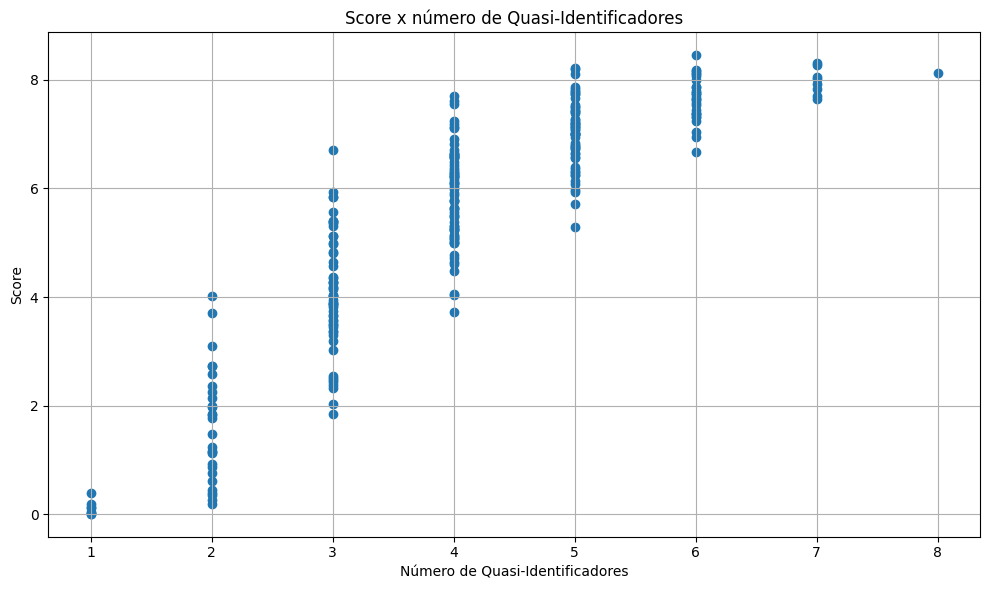

In [72]:
plt.figure(figsize=(10, 6))
plt.scatter(estatisticas_df['num_qi'], estatisticas_df['novo_score_final'])
plt.xlabel('Número de Quasi-Identificadores')
plt.ylabel('Score')
plt.title('Score x número de Quasi-Identificadores')
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
melhor = estatisticas_df.loc[estatisticas_df['novo_score_final'].idxmax()]

print("🔍 Melhor combinação (novo score refinado):")
print(f"QIs: {melhor['combinacao']}")
print(f"Score: {melhor['novo_score_final']:.4f}")
print(f"Total de grupos: {melhor['total_grupos']}")
print(f"Proporção de grupos de tamanho 1: {melhor['proporcao_tam_1']:.2%}")
print(f"Confiança média: {melhor['confianca']:.2f}")

🔍 Melhor combinação (novo score refinado):
QIs: ('1.i.1_uf_onde_mora', '2.f_cargo_atual', '1.l_nivel_de_ensino', '1.m_área_de_formação', '2.b_setor', '2.c_numero_de_funcionarios')
Score: 8.4512
Total de grupos: 3103
Proporção de grupos de tamanho 1: 89.27%
Confiança média: 9.00


## Desanonimização

In [118]:
quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    '2.i_tempo_de_experiencia_em_dados',
    '2.j_tempo_de_experiencia_em_ti',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    # '2.b_setor',
    # '2.c_numero_de_funcionarios',
    '2.f_cargo_atual'
]

df_anon = pd.read_csv("state_of_the_data_dataset.csv")
df_ident = pd.read_csv("linkedin_profiles_data.csv")

grupos_anon = df_anon.groupby(quasi_identifiers).size().reset_index(name='k_frequencia')

grupos_anon = grupos_anon.sort_values(by='k_frequencia', ascending=True).reset_index(drop=True)

grupos_anon['id_classe_equivalencia'] = range(1, len(grupos_anon) + 1)

colunas_reordenadas = ['id_classe_equivalencia', 'k_frequencia'] + [col for col in grupos_anon.columns if col not in ['id_classe_equivalencia', 'k_frequencia']]
grupos_anon = grupos_anon[colunas_reordenadas]

grupos_anon.to_csv("classes_equivalencia.csv", index=False)

df_anon_com_id = df_anon.merge(grupos_anon, on=quasi_identifiers, how='left')
df_ident_com_id = df_ident.merge(grupos_anon, on=quasi_identifiers, how='left')


In [120]:
# Passo 1: Filtrar entradas anonimizadas com k == 1
ids_unicos = df_anon_com_id[df_anon_com_id['k_frequencia'] == 1]['id_classe_equivalencia'].unique()

# Passo 2: Filtrar entradas no df_ident que pertencem a essas classes
df_reidentificaveis = df_ident_com_id[df_ident_com_id['id_classe_equivalencia'].isin(ids_unicos)]

# Passo 3: Selecionar colunas relevantes
df_resultado = df_reidentificaveis[['nome', 'link_perfil', 'id_classe_equivalencia']].copy()

# (Opcional) Ordenar por id_classe_equivalencia para melhor leitura
df_resultado = df_resultado.sort_values(by='id_classe_equivalencia').reset_index(drop=True)

# Exportar se quiser
df_resultado.to_csv("possiveis_reidentificacoes.csv", index=False)
